In [1]:
%pip install pyomo

  Using cached Pyomo-5.7.1.tar.gz (2.1 MB)
  Using cached PyUtilib-6.0.0-py2.py3-none-any.whl (254 kB)
  Created wheel for pyomo: filename=Pyomo-5.7.1-cp37-cp37m-macosx_10_9_x86_64.whl size=4174930 sha256=a528a46ab9a69bed4f07b22828f13c793308f635f9470c65f4080867f399a193
  Stored in directory: /Users/joseangelvelasco/Library/Caches/pip/wheels/90/31/7f/98c26b968786067573211c7f392802e462f93cf74b9ed2dafe
Successfully built pyomo
Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings("ignore")
import pyomo.environ as pyo 
import math
import pandas as pd
import numpy as np
plt.rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt

## Notes
* OPF for unbalance three-phase network
* The solver does not use per unit values
* 4 wire cables are transformed into 3x3 primitive matrices with Kron's reduction
* P. Garcia et all, 'Three-phase power flow calculations using the current injection method', IEEE Transactions on Power Systems, 2000
* Voltages are initialized considering the transformer step up and delta wye connection (30 degrees rotation)


## OPF for demand response
* System has PV
* Demand response from each house


In [3]:
# Abstract model
model = pyo.AbstractModel() 

# settings
cosphi_constant=1.0
tanphi_constant=-math.tan(math.acos(cosphi_constant))
upper_voltage_limit=1.078
lower_voltage_limit=0.9
main_cable_Alimit=150.0 # Need to add this constraint latter
DR_alpha = 1.0


# Sets
if 1==1:
    model.Buses = pyo.Set(dimen=1)
    model.Phases_abc = pyo.Set(dimen=1) # The model presumes a Kron reduction of the primitive matrices
    model.time = pyo.Set(dimen=1)
    model.data_time = pyo.Set(dimen=1)
    model.Lines = pyo.Set(dimen=1)
    model.Loads = pyo.Set(dimen=1)
    model.PVs = pyo.Set(dimen=1)
    
## Parameters (Variables) ##
if 1 == 1:
    # Network parameters
    if 1==1:
        model.Bus_G = pyo.Param(model.Buses,model.Buses,model.Phases_abc,model.Phases_abc) # Network conductivity matrix
        model.Bus_B = pyo.Param(model.Buses,model.Buses,model.Phases_abc,model.Phases_abc) # Network susceptance matrix
        model.Connectivity = pyo.Param(model.Buses,model.Buses) # Connectivity matrix 1 if bus k and bus i are connected (zero otherwise)
        model.Lines_k= pyo.Param(model.Lines) # Lines sending buses
        model.Lines_i= pyo.Param(model.Lines) # Lines receiving buses
    # Loads
    if 1==1:
        # Load 
        model.Load_bus_conn= pyo.Param(model.Loads)
        model.Load_phase_conn = pyo.Param(model.Loads)
        model.Load_Vnom = pyo.Param(model.Loads)
        # Demand
        model.PDem= pyo.Param(model.Loads,model.data_time) #W
        model.QDem= pyo.Param(model.Loads,model.data_time) #VA
        model.ZIP_P_P= pyo.Param(model.Loads,model.data_time)
        model.ZIP_P_I= pyo.Param(model.Loads,model.data_time)
        model.ZIP_P_Z= pyo.Param(model.Loads,model.data_time)
        model.ZIP_Q_P= pyo.Param(model.Loads,model.data_time)
        model.ZIP_Q_I= pyo.Param(model.Loads,model.data_time)
        model.ZIP_Q_Z= pyo.Param(model.Loads,model.data_time)
    # PV Generation
    if 1==1:
        model.Percent_Gen= pyo.Param(model.data_time) # Percent generation - function of solar irradiance
        model.PV_sizes= pyo.Param(model.PVs) # Size of each PV in the system
        model.PVs_bus_conn= pyo.Param(model.PVs) # Defines the bus to which each PV is connected
        model.PVs_phase_conn= pyo.Param(model.PVs) # Defines the phase to which each PV is connected
        
    # Variables initialization values
    if 1==1:
        model.Vinitre_pu= pyo.Param(model.Buses,model.Phases_abc,model.data_time) # Values used to initialize the real and imaginary voltages for the solver
        model.Vinitim_pu= pyo.Param(model.Buses,model.Phases_abc,model.data_time)
        model.Vinit= pyo.Param(model.Buses,model.Phases_abc,model.data_time) # Nominal phase voltage for the loads ZIP e.g. 230

        
## PF Variables ## 
if 1==1:
    # Voltages - Real and Imaginary part
    if 1==1:
        # Initialization rules
        def init_Vre_rule(model, k, s, t):
            return model.Vinitre_pu[k,s,t]*model.Vinit[k,s,t]
        def init_Vim_rule(model, k, s, t):
            return model.Vinitim_pu[k,s,t]*model.Vinit[k,s,t]
        # Variables definition
        model.Vre = pyo.Var(model.Buses,model.Phases_abc,model.time, initialize=init_Vre_rule)  # Real and imaginary phase voltages
        model.Vim = pyo.Var(model.Buses,model.Phases_abc,model.time, initialize=init_Vim_rule)    
    # Current flows
    if 1==1:
        model.Iflow_re = pyo.Var(model.Lines,model.Phases_abc,model.time)
        model.Iflow_im = pyo.Var(model.Lines,model.Phases_abc,model.time)
    # PQ flows
    if 1==1:
        model.P_flow_sending = pyo.Var(model.Lines,model.Phases_abc,model.time)
        model.Q_flow_sending = pyo.Var(model.Lines,model.Phases_abc,model.time)
        model.P_flow_receiving = pyo.Var(model.Lines,model.Phases_abc,model.time)
        model.Q_flow_receiving = pyo.Var(model.Lines,model.Phases_abc,model.time)
    # Losses
    if 1==1:
        model.Plosses_line = pyo.Var(model.Lines,model.Phases_abc,model.time)
    # Auxiliary variables for power flow
    if 1==1:
        # Real and imaginary specified current injections for the current missmatch
        model.Isp_re = pyo.Var(model.Buses,model.Phases_abc,model.time, initialize=0.0)
        model.Isp_im = pyo.Var(model.Buses,model.Phases_abc,model.time, initialize=0.0)
    # Dummy variables
    model.Dummy = pyo.Var(initialize=0, within=pyo.NonNegativeReals) # Dummy variable just to have something to put in the objective function
    
# Control Variables 
if 1==1:
    # Demand response
    if 1==1:
        model.deltaP = pyo.Var(model.Loads,model.time, initialize=0.0)
    
## Expressions ##
if 1==1:   
    # PV generation
    if 1==1:
        def PV_P_rule(model, pv, t):
            return model.Percent_Gen[t]*model.PV_sizes[pv]*1000*1
        model.PV_P = pyo.Expression(model.PVs,model.time, rule=PV_P_rule) # Active power generation at each bus from PVs
        def PV_Q_rule(model, pv, t): 
            return model.Percent_Gen[t]*model.PV_sizes[pv]*1000*tanphi_constant
        model.PV_Q= pyo.Expression(model.PVs,model.time, rule=PV_Q_rule) # Reactive power generation at each bus from PVs
    # Power injection per node
    if 1==1:
        # Active Power demand ZIP
        def ZIP_P_rule(model, k, s, t):
            return sum(model.deltaP[h,t] + model.PDem[h,t] * (model.ZIP_P_P[h,t] + model.ZIP_P_I[h,t] * ((pyo.sqrt(model.Vre[k,s,t]**2+model.Vim[k,s,t]**2))/model.Load_Vnom[h]) + model.ZIP_P_Z[h,t] * (model.Vre[k,s,t]**2+model.Vim[k,s,t]**2)/(model.Load_Vnom[h]**2)) for h in model.Loads if (model.Load_bus_conn[h]==k and model.Load_phase_conn[h]==s))            
        model.PDem_ZIP = pyo.Expression(model.Buses,model.Phases_abc,model.time,  rule=ZIP_P_rule)
        # Reactive Power demand ZIP
        def ZIP_Q_rule(model, k, s, t):
            return sum(model.QDem[h,t] * (model.ZIP_Q_P[h,t] + model.ZIP_Q_I[h,t] * ((pyo.sqrt(model.Vre[k,s,t]**2+model.Vim[k,s,t]**2))/model.Load_Vnom[h]) + model.ZIP_Q_Z[h,t] * (model.Vre[k,s,t]**2+model.Vim[k,s,t]**2)/(model.Load_Vnom[h]**2)) for h in model.Loads if (model.Load_bus_conn[h]==k and model.Load_phase_conn[h]==s)) 
        model.QDem_ZIP = pyo.Expression(model.Buses,model.Phases_abc,model.time,  rule=ZIP_Q_rule)
        # Active power generation
        def PGen_rule(model, k, s, t):
            return sum(model.PV_P[pv,t] for pv in model.PVs if (model.PVs_bus_conn[pv]==k and model.PVs_phase_conn[pv]==s))            
        model.PGen = pyo.Expression(model.Buses,model.Phases_abc,model.time,  rule=PGen_rule)
        def QGen_rule(model, k, s, t):
            return sum(model.PV_Q[pv,t] for pv in model.PVs if (model.PVs_bus_conn[pv]==k and model.PVs_phase_conn[pv]==s))            
        model.QGen = pyo.Expression(model.Buses,model.Phases_abc,model.time,  rule=QGen_rule)
        # Power injections per node (generation - demand)
        def Psp_rule(model, k, s, t):
            return model.PGen[k,s,t] - model.PDem_ZIP[k,s,t]
        model.Psp = pyo.Expression(model.Buses,model.Phases_abc,model.time, rule=Psp_rule)
        def Qsp_rule(model, k, s, t):
            return model.QGen[k,s,t] - model.QDem_ZIP[k,s,t]
        model.Qsp = pyo.Expression(model.Buses,model.Phases_abc,model.time, rule=Qsp_rule)
    # Current injections
    if 1==1:
        # Specified current injection (from specified PQ injections)
        if 1==1:
            # They are specified as a constraint to as to avoid more complex expressions (simpler to solve.. don't need to divide by the voltage)
            def I_sp_re_rule(model, k, s, t): # Real specified current injection per node and phase
                return model.Psp[k,s,t] == model.Vre[k,s,t] * model.Isp_re[k,s,t] + model.Vim[k,s,t] * model.Isp_im[k,s,t]
            model.Isp_re_con = pyo.Constraint(model.Buses,model.Phases_abc,model.time, rule=I_sp_re_rule) 
            def I_sp_im_rule(model, k, s, t): # Imaginary specified current injection per node and phase
                return model.Qsp[k,s,t] == model.Vim[k,s,t] * model.Isp_re[k,s,t] - model.Vre[k,s,t] * model.Isp_im[k,s,t]
            model.Isp_im_con = pyo.Constraint(model.Buses,model.Phases_abc,model.time, rule=I_sp_im_rule)
        # Calculated current injection (from voltages and admittances)
        if 1==1:
            # Expressions for currents
            def I_calc_re_rule(model, k, s, t): # Real calculated current injection   
                return sum(sum( model.Bus_G[k,i,s,a]*model.Vre[i,a,t] - model.Bus_B[k,i,s,a]*model.Vim[i,a,t] for a in model.Phases_abc) for i in model.Buses if model.Connectivity[k,i] == 1)
            model.Icalc_re = pyo.Expression(model.Buses,model.Phases_abc,model.time, rule=I_calc_re_rule) 
            def I_calc_im_rule(model, k, s, t): # Imaginary calculated current injection   
                return sum(sum( model.Bus_G[k,i,s,a]*model.Vim[i,a,t] + model.Bus_B[k,i,s,a]*model.Vre[i,a,t] for a in model.Phases_abc) for i in model.Buses if model.Connectivity[k,i] == 1)
            model.Icalc_im = pyo.Expression(model.Buses,model.Phases_abc,model.time, rule=I_calc_im_rule)
    
    ## Power flow variables
    # Current line flows
    if 1==0:
        def I_flow_re_rule(model, l, s, t): # Real line flows
            return model.Iflow_re[l,s,t] == sum(model.Bus_G[model.Lines_k[l],model.Lines_i[l],s,a]*(model.Vre[model.Lines_i[l],a,t]-model.Vre[model.Lines_k[l],a,t]) - model.Bus_B[model.Lines_k[l],model.Lines_i[l],s,a]*(model.Vim[model.Lines_i[l],a,t]-model.Vim[model.Lines_k[l],a,t]) for a in model.Phases_abc)
        model.Iflow_re_con = pyo.Constraint(model.Lines,model.Phases_abc,model.time, rule=I_flow_re_rule) 
        def I_flow_im_rule(model, l, s, t): # Imaginary line flows
            return model.Iflow_im[l,s,t] == sum(model.Bus_B[model.Lines_k[l],model.Lines_i[l],s,a]*(model.Vre[model.Lines_i[l],a,t]-model.Vre[model.Lines_k[l],a,t]) + model.Bus_G[model.Lines_k[l],model.Lines_i[l],s,a]*(model.Vim[model.Lines_i[l],a,t]-model.Vim[model.Lines_k[l],a,t]) for a in model.Phases_abc)
        model.Iflow_im_con = pyo.Constraint(model.Lines,model.Phases_abc,model.time, rule=I_flow_im_rule) 
    # PQ line flows
    if 1==0:
        def P_flow_sending_rule(model, l, s, t): # P sending flow
            return model.P_flow_sending[l,s,t] == model.Vre[model.Lines_k[l],s,t] * model.Iflow_re[l,s,t] + model.Vim[model.Lines_k[l],s,t] * model.Iflow_im[l,s,t]
        model.P_flow_sending_con = pyo.Constraint(model.Lines,model.Phases_abc,model.time, rule=P_flow_sending_rule)    
        def P_flow_receiving_rule(model, l, s, t): # P receiving flow
            return model.P_flow_receiving[l,s,t] == -1 *(model.Vre[model.Lines_i[l],s,t] * model.Iflow_re[l,s,t] + model.Vim[model.Lines_i[l],s,t] * model.Iflow_im[l,s,t])  
        model.P_flow_receiving_con = pyo.Constraint(model.Lines,model.Phases_abc,model.time, rule=P_flow_receiving_rule)
        def Q_flow_sending_rule(model, l, s, t): # Q sending flow
            return model.Q_flow_sending[l,s,t] == model.Vim[model.Lines_k[l],s,t] * model.Iflow_re[l,s,t] - model.Vre[model.Lines_k[l],s,t] * model.Iflow_im[l,s,t]
        model.Q_flow_sending_con = pyo.Constraint(model.Lines,model.Phases_abc,model.time, rule=Q_flow_sending_rule)    
        def Q_flow_receiving_rule(model, l, s, t): # Q receiving flow
            return model.Q_flow_receiving[l,s,t] == -1 *(model.Vim[model.Lines_i[l],s,t] * model.Iflow_re[l,s,t] - model.Vre[model.Lines_i[l],s,t] * model.Iflow_im[l,s,t])  
        model.Q_flow_receiving_con = pyo.Constraint(model.Lines,model.Phases_abc,model.time, rule=Q_flow_receiving_rule)
    # Losses
    if 1==0:
        def Plosses_line_rule(model, l, s, t): # P sending flow
            return model.Plosses_line[l,s,t] == model.P_flow_sending[l,s,t] + model.P_flow_receiving[l,s,t]
        model.Plosses_line_con = pyo.Constraint(model.Lines,model.Phases_abc,model.time, rule=Plosses_line_rule)         
    
## Constraints ##
if 1==1:
    # Power flow constraints
    if 1==1:
        # Current mismatch
        def I_delta_re_rule(model, k, s, t): # Real part
            if k=='slack':
                return pyo.Constraint.Skip
            else:
                return model.Isp_re[k,s,t] - model.Icalc_re[k,s,t] == 0
        model.Idelta_re_con = pyo.Constraint(model.Buses,model.Phases_abc,model.time, rule=I_delta_re_rule)
        def I_delta_im_rule(model, k, s, t): # Imaginary part
            if k=='slack':
                return pyo.Constraint.Skip
            else:
                return model.Isp_im[k,s,t] - model.Icalc_im[k,s,t] == 0
        model.Idelta_im_con = pyo.Constraint(model.Buses,model.Phases_abc,model.time, rule=I_delta_im_rule)
       
        # Slack constraint
        def Slack_re_rule(model, k, s, t): # Real part
            if k=='slack':
                return model.Vre[k,s,t]==model.Vinitre_pu[k,s,t]*model.Vinit[k,s,t]
            else:
                return pyo.Constraint.Skip
        def Slack_im_rule(model, k, s, t): # Imaginary part
            if k=='slack':
                return model.Vim[k,s,t]==model.Vinitim_pu[k,s,t]*model.Vinit[k,s,t]
            else:
                return pyo.Constraint.Skip
        model.Slack_re_con = pyo.Constraint(model.Buses,model.Phases_abc,model.time, rule=Slack_re_rule) # Real part
        model.Slack_im_con = pyo.Constraint(model.Buses,model.Phases_abc,model.time, rule=Slack_im_rule) # Imaginary part
    # System state constraints
    if 1==1:
        # Statutory limits
        if 1==1:
            def Voltage_upper_lim_rule(model, h, t): # Again considers that PVs and loads match bus
                return model.Vre[model.Load_bus_conn[h],model.Load_phase_conn[h],t]**2+model.Vim[model.Load_bus_conn[h],model.Load_phase_conn[h],t]**2 <= (upper_voltage_limit * model.Load_Vnom[h])**2 # Writen in terms of the square of the votage to avoid function sqrt() in formulation
            model.Voltage_upper_lim_con = pyo.Constraint(model.Loads,model.time, rule=Voltage_upper_lim_rule) 
            def Voltage_lower_lim_rule(model, h, t): # Again considers that PVs and loads match bus
                return model.Vre[model.Load_bus_conn[h],model.Load_phase_conn[h],t]**2+model.Vim[model.Load_bus_conn[h],model.Load_phase_conn[h],t]**2 >= (lower_voltage_limit * model.Load_Vnom[h])**2 # Writen in terms of the square of the votage to avoid function sqrt() in formulation
            model.Voltage_lower_lim_con = pyo.Constraint(model.Loads,model.time, rule=Voltage_lower_lim_rule) 
    
    # Control variables constraints
    if 1==1:
        # Demand response energy
        if 1==1:
            def deltaP_energy_rule(model, l):
                return sum(model.deltaP[l,t] for t in model.time) == 0
            model.deltaP_energy_con = pyo.Constraint(model.Loads, rule=deltaP_energy_rule)
        # Demand response capabilities
        Loads_set = pd.read_csv('Loads_pyomo.csv')
        Loads_Dem = pd.read_csv('Loads_Dem_pyomo.csv')
        if 1==1:
            # First find max demand
            Pdem_max = pd.DataFrame(index=Loads_set['Loads'].values,columns=['max_kW'])
            for i_load in Loads_set.index: 
                Pdem_max.iloc[i_load]['max_kW'] = Loads_Dem[Loads_Dem['Loads']==Loads_set.loc[i_load,'Loads']]['PDem'].max(0)
            # Limit the max demand response value
            def deltaP_cap_up_rule(model, l ,t):
                return model.deltaP[l,t] <= DR_alpha * float(Pdem_max.loc[l,'max_kW'])
            model.deltaP_cap_up_con = pyo.Constraint(model.Loads,model.time, rule=deltaP_cap_up_rule)
            def deltaP_cap_low_rule(model, l ,t):
                return model.deltaP[l,t] >= -1 * DR_alpha * float(Pdem_max.loc[l,'max_kW'])
            model.deltaP_cap_low_con = pyo.Constraint(model.Loads,model.time, rule=deltaP_cap_low_rule)
        
## Objective function ##
if 1==1:
    # Dummy objective function
    if 1==0:
        model.obj = pyo.Objective(expr=model.Dummy)
    # Min use of DR
    if 1==1:
        def Objective_rule(model):
            return sum(sum(model.deltaP[l,t]**2 for l in model.Loads) for t in model.time)
        model.obj = pyo.Objective(rule=Objective_rule)   
    # Min use of DR energy constraint
    if 1==0:
        def Objective_rule(model):
            return sum(sum(model.deltaP[l,t]**2 for l in model.Loads) for t in model.time) + 1e5 * sum(model.DR_rel_energy_missmatch[l]**2 for l in model.Loads)
        model.obj = pyo.Objective(rule=Objective_rule)  
    if 1==0:
        def Objective_rule(model):
            return sum(sum(abs(model.deltaP[l,t]) for l in model.Loads) for t in model.time) + 1e5 * sum(model.DR_rel_energy_missmatch[l]**2 for l in model.Loads)
        model.obj = pyo.Objective(rule=Objective_rule)



In [4]:
print('Solving OPF')
instance = model.create_instance('Model_data.dat')
if 1==1:
    optimizer = pyo.SolverFactory('ipopt')
    optimizer.options['max_iter'] = 100000
if 1==0:
    optimizer = pyo.SolverFactory('knitroampl')
    optimizer.options["par_numthreads"] = 4

solver_results = optimizer.solve(instance, tee=True)
print('OPF solved')
# Objective function
print('Objective= ' + str(instance.obj.expr()))


Solving OPF
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (Lines_k) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from
    /Users/joseangelvelasco/anaconda3/lib/python3.7/site-
    packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (Lines_k) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from
    /Users/joseangelvelasco/anaconda3/lib/python3.7/site-
    packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (Lines_k) to be 'Any', you can suppress
    this warning by explicitly spe

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (Lines_k) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from
    /Users/joseangelvelasco/anaconda3/lib/python3.7/site-
    packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (Lines_k) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from
    /Users/joseangelvelasco/anaconda3/lib/python3.7/site-
    packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (Lines_k) to be 'Any', you can suppress
    this warning by explicitly specifying 'wit

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (Lines_i) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from
    /Users/joseangelvelasco/anaconda3/lib/python3.7/site-
    packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (Lines_i) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from
    /Users/joseangelvelasco/anaconda3/lib/python3.7/site-
    packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (Lines_i) to be 'Any', you can suppress
    this warning by explicitly specifying 'wit

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (Lines_i) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from
    /Users/joseangelvelasco/anaconda3/lib/python3.7/site-
    packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (Lines_i) to be 'Any', you can suppress
    this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from
    /Users/joseangelvelasco/anaconda3/lib/python3.7/site-
    packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (Lines_i) to be 'Any', you can suppress
    this warning by explicitly specifying 'wit

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (Load_bus_conn) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from
    /Users/joseangelvelasco/anaconda3/lib/python3.7/site-
    packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (Load_bus_conn) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from
    /Users/joseangelvelasco/anaconda3/lib/python3.7/site-
    packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (Load_bus_conn) to be 'Any', you can
    suppress this warning by explicit

    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (PVs_bus_conn) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from
    /Users/joseangelvelasco/anaconda3/lib/python3.7/site-
    packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (PVs_bus_conn) to be 'Any', you can
    suppress this warning by explicitly specifying 'within=Any' to the Param
    constructor.  (deprecated in 5.6.9, will be removed in 6.0) (called from
    /Users/joseangelvelasco/anaconda3/lib/python3.7/site-
    packages/pyomo/core/base/param.py:640)
    we will be changing that default to 'Reals' in the future.  If you really
    intend the domain of this Param (PVs_bus_conn) to be 'Any', you can
    suppress this warning by explicitly 

  34  1.8453118e+08 9.63e+02 3.64e+03  -1.0 1.86e+03    -  3.31e-05 2.24e-05f  1
  35  1.8452808e+08 9.63e+02 3.64e+03  -1.0 1.98e+03    -  4.66e-05 1.68e-05f  1
  36  1.8452028e+08 9.62e+02 3.64e+03  -1.0 2.02e+03    -  1.18e-04 5.09e-05f  1
  37  1.8451111e+08 9.62e+02 3.64e+03  -1.0 2.08e+03    -  1.68e-04 7.84e-05f  1
  38  1.8450823e+08 9.62e+02 3.64e+03  -1.0 2.10e+03    -  1.26e-03 4.03e-05f  1
  39  1.8450714e+08 9.62e+02 3.64e+03  -1.0 2.10e+03    -  2.90e-04 3.17e-05f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.8450701e+08 9.62e+02 3.64e+03  -1.0 2.10e+03    -  7.07e-03 4.59e-06f  1
  41  1.8450710e+08 9.62e+02 3.64e+03  -1.0 6.76e+03    -  2.79e-04 1.91e-05h  1
  42  1.8450672e+08 9.62e+02 1.51e+04  -1.0 3.11e+03    -  7.58e-03 1.30e-05f  1
  43  1.8450630e+08 9.62e+02 2.10e+04  -1.0 9.03e+03    -  2.53e-04 1.42e-04f  1
  44  1.8451441e+08 9.62e+02 2.28e+04  -1.0 3.73e+04    -  5.20e-05 4.76e-05h  1
  45r 1.8451441e+08 9.62e+02

 127  2.2878547e+08 1.76e+01 2.92e+06  -1.0 1.52e+03    -  1.29e-03 8.05e-04h  1
 128  2.2879111e+08 1.76e+01 2.92e+06  -1.0 1.51e+03    -  1.27e-03 4.23e-05h  1
 129  2.2881000e+08 1.76e+01 3.03e+06  -1.0 4.41e+04    -  2.71e-04 1.45e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130r 2.2881000e+08 1.76e+01 1.00e+03  -0.2 0.00e+00    -  0.00e+00 3.03e-07R  7
 131r 2.2969480e+08 2.05e+01 9.76e+02  -0.2 6.98e+02    -  7.59e-02 2.34e-02f  1
 132r 2.3088769e+08 2.66e+01 9.41e+02  -0.2 7.04e+02    -  7.25e-02 3.58e-02f  1
 133r 2.3163736e+08 2.74e+01 9.14e+02  -0.2 8.12e+02    -  7.52e-02 2.91e-02f  1
 134r 2.3221853e+08 2.69e+01 8.93e+02  -0.2 7.87e+02    -  1.34e-01 2.30e-02f  1
 135r 2.3332911e+08 2.83e+01 8.53e+02  -0.2 7.96e+02    -  7.56e-02 4.43e-02f  1
 136r 2.3564877e+08 3.12e+01 7.69e+02  -0.2 7.67e+02    -  1.98e-01 9.89e-02f  1
 137r 2.3695201e+08 3.28e+01 7.21e+02  -0.2 5.85e+02    -  1.35e-01 6.24e-02f  1
 138r 2.3969278e+08 3.61e+01

 249r 6.4397974e+08 2.61e+01 4.79e+01  -8.1 1.16e+03  -6.6 2.29e-02 1.33e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250r 6.4412312e+08 2.61e+01 4.67e+01  -8.1 4.61e+02  -6.2 1.11e-02 1.72e-02f  1
In iteration 250, 1 Slack too small, adjusting variable bound
 251r 6.4457002e+08 2.61e+01 4.56e+01  -8.1 1.32e+03  -6.6 1.17e-02 1.71e-02f  1
 252r 6.4464929e+08 2.61e+01 4.89e+01  -8.1 5.14e+02  -6.2 7.31e-02 8.18e-03f  1
 253r 6.4528804e+08 2.61e+01 4.67e+01  -8.1 1.26e+03  -6.7 1.57e-02 2.98e-02f  1
In iteration 253, 1 Slack too small, adjusting variable bound
 254r 6.4541504e+08 2.61e+01 4.58e+01  -8.1 4.41e+02  -6.3 1.30e-02 1.59e-02f  1
 255r 6.4542610e+08 2.61e+01 4.79e+01  -8.1 1.82e+03  -6.7 3.99e-02 3.06e-04f  1
 256r 6.4584449e+08 2.61e+01 4.39e+01  -8.1 4.91e+02  -6.3 2.14e-03 4.16e-02f  1
 257r 6.4710984e+08 2.62e+01 4.29e+01  -8.1 3.13e+03  -6.8 1.92e-02 2.12e-02f  1
 258r 6.4717849e+08 2.63e+01 4.34e+01  -8.1 4.29e+02  -6.4 1.97e-0

 441r 9.8452270e+08 1.49e+02 9.74e-01  -8.1 7.23e+02  -7.0 3.47e-01 1.78e-02f  1
 442r 9.8535224e+08 1.49e+02 8.49e-01  -8.1 2.44e+02  -6.6 3.98e-02 1.35e-01f  1
 443r 9.8586655e+08 1.49e+02 8.22e-01  -8.1 1.01e+03  -7.0 3.74e-01 2.99e-02f  1
 444r 9.8870224e+08 1.49e+02 4.88e-01  -8.1 2.76e+02  -6.6 2.05e-01 4.17e-01f  1
 445r 9.8904452e+08 1.49e+02 4.99e-01  -8.1 1.38e+03  -7.1 9.64e-01 1.62e-02f  1
 446r 9.9052457e+08 1.49e+02 4.01e-01  -8.1 3.37e+02  -6.7 5.08e-01 1.80e-01f  1
 447r 9.9125465e+08 1.49e+02 4.08e-01  -8.1 1.85e+03  -7.1 5.94e-01 2.87e-02f  1
 448r 9.9186889e+08 1.49e+02 3.52e-01  -8.1 3.92e+02  -6.7 4.45e-01 8.26e-02f  1
 449r 9.9256696e+08 1.49e+02 3.45e-01  -8.1 2.49e+03  -7.2 3.53e-01 2.63e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450r 9.9473619e+08 1.49e+02 2.59e-01  -8.1 4.81e+02  -6.8 2.45e-01 2.50e-01f  1
 451r 9.9515709e+08 1.49e+02 5.05e-01  -8.1 4.05e+03  -7.2 3.42e-01 1.08e-02f  1
 452r 9.9687116e+08 1.49e+02

In iteration 594, 2 Slacks too small, adjusting variable bounds
 595r 1.4797164e+09 1.48e+02 6.87e-01  -9.0 7.23e+02  -6.9 3.47e-02 2.87e-02h  1
In iteration 595, 2 Slacks too small, adjusting variable bounds
 596r 1.4802896e+09 1.48e+02 6.15e-01  -9.0 2.47e+02  -6.5 3.11e-01 4.34e-02h  1
In iteration 596, 1 Slack too small, adjusting variable bound
 597r 1.4828665e+09 1.48e+02 5.78e-01  -9.0 8.44e+02  -7.0 5.14e-02 5.66e-02h  1
In iteration 597, 1 Slack too small, adjusting variable bound
 598r 1.4843180e+09 1.48e+02 5.18e-01  -9.0 2.79e+02  -6.5 3.34e-01 9.25e-02h  1
In iteration 598, 1 Slack too small, adjusting variable bound
 599r 1.4861979e+09 1.48e+02 5.01e-01  -9.0 1.25e+03  -7.0 3.33e-02 3.33e-02h  1
In iteration 599, 1 Slack too small, adjusting variable bound
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600r 1.4864791e+09 1.48e+02 5.18e-01  -9.0 3.07e+02  -6.6 2.03e-01 1.57e-02h  1
In iteration 600, 1 Slack too small, adjusting variable b

    model=unknown;
        message from solver=Ipopt 3.12.12\x3a Converged to a locally
        infeasible point. Problem may be infeasible.
OPF solved


In [6]:
Bus_set = pd.read_csv('Buses_pyomo.csv')
Time_sim = pd.read_csv('Time_pyomo.csv')
Lines_set = pd.read_csv('Lines_pyomo.csv')
Loads_data_pyomo = pd.read_csv('Loads_data_pyomo.csv')


# SE Power flow variables
SE_Bus_Vmag = np.zeros([Time_sim.size, Bus_set.size,3])
SE_P_line = np.zeros([Time_sim.size, Lines_set.size,3]) # Sending values
SE_Q_line = np.zeros([Time_sim.size, Lines_set.size,3])
SE_Ire_line = np.zeros([Time_sim.size, Lines_set.size,3])
SE_Iim_line = np.zeros([Time_sim.size, Lines_set.size,3])
SE_Imag_line = np.zeros([Time_sim.size, Lines_set.size,3])
SE_Losses_line = np.zeros([Time_sim.size, Lines_set.size,3])
SE_Losses_sign_line = np.zeros([Time_sim.size, Lines_set.size,3])

for count_t in range(Time_sim.size):
    i_time = Time_sim.loc[count_t,'time']
    # nodal voltages
    for i_bus in range(len(Bus_set)):
        for phase in range(3):
            SE_Bus_Vmag[count_t,i_bus,phase] = math.sqrt(instance.Vre[Bus_set.loc[i_bus,'Buses'],phase+1,i_time].value**2 + instance.Vim[Bus_set.loc[i_bus,'Buses'],phase+1,i_time].value**2)

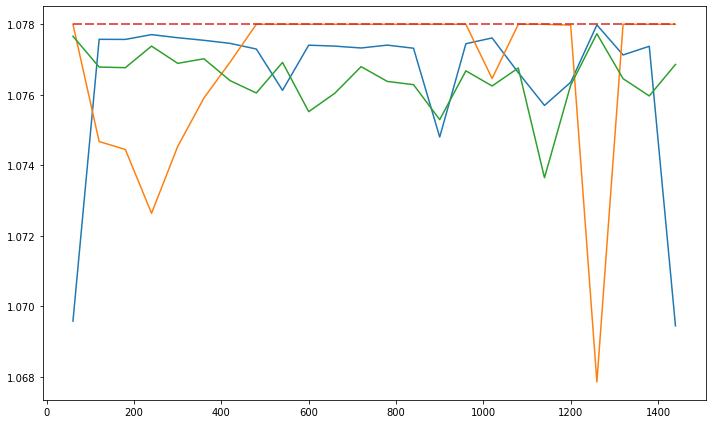

In [8]:
""" PLOTS """


# Voltage plot
load = 'LOAD23'
fig3, ax = plt.subplots(1, figsize=(10, 6), tight_layout=True)
bus = Loads_data_pyomo.loc[Loads_data_pyomo['Loads']==load,'Load_bus_conn'].values[0]
phase = Loads_data_pyomo.loc[Loads_data_pyomo['Loads']==load,'Load_phase_conn'].values[0]
to_plot_SE=np.zeros([len(Time_sim),3])
upper_V=np.zeros([len(Time_sim)])
lower_V=np.zeros([len(Time_sim)])
for i in range(len(Time_sim)):
    for phase in range(3):
        to_plot_SE[i,phase] = SE_Bus_Vmag[i,Loads_data_pyomo.loc[Loads_data_pyomo['Loads']==load,'Load_bus_conn'].index[0],phase] / (400/math.sqrt(3))
    upper_V[i] = upper_voltage_limit
    lower_V[i] = lower_voltage_limit
for phase in range(3):
    ax.plot(Time_sim, to_plot_SE[:,phase].T)
ax.plot(Time_sim, upper_V,dashes=[6, 2])
#ax.plot(Time_sim, lower_V,dashes=[6, 2])
plt.show()


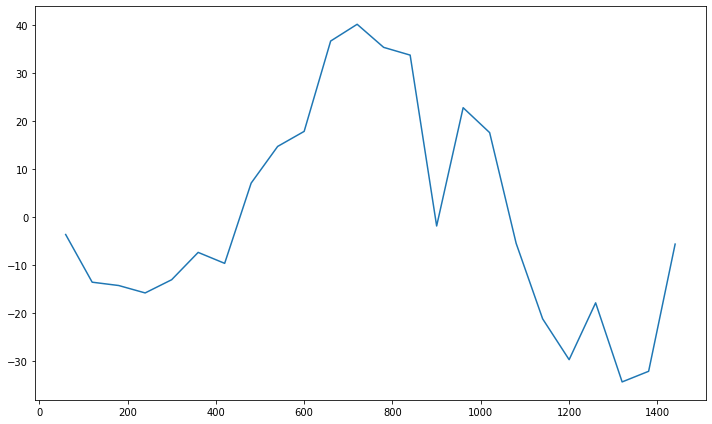

In [10]:
# DR usage
fig3, ax = plt.subplots(1, figsize=(10, 6), tight_layout=True)
to_plot_SE=np.zeros([len(Time_sim)])
for i in range(len(Time_sim)):
    i_time = Time_sim.loc[i,'time']
    obj_sum = 0
    for i_load in range(len(Loads_set)):
        obj_sum = obj_sum + instance.deltaP[Loads_set.loc[i_load,'Loads'],i_time].value / 1000.0
    to_plot_SE[i] = obj_sum
ax.plot(Time_sim, to_plot_SE)
plt.show()

